In [31]:
from PIL import Image
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import save_image

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.rb = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
    def forward(self, x):
        out = self.rb(x)
        out = torch.add(x, out)
        return out


class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super(UpSampleBlock, self).__init__()
        self.upsample_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.PReLU()
        )
    def forward(self, x):
        out = self.upsample_block(x)
        return out


class SRResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=16, upscale_factor=4):
        super(SRResNet, self).__init__()
        assert upscale_factor in [2, 4, 8], "Upscale factor must be one of [2, 4, 8]."
        self.in_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )
        self.res_out_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.upsample_blocks = nn.Sequential(
            *[UpSampleBlock(64, 64) for _ in range(upscale_factor // 2)]
        )
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.in_conv(x)
        residual = x
        x = self.residual_blocks(x)
        x = self.res_out_conv(x)
        x = torch.add(x, residual)
        x = self.upsample_blocks(x)
        x = self.out_conv(x)
        return x

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=5, upscale_factor=4):
        super(Generator, self).__init__()
        self.srresnet = SRResNet(in_channels, out_channels, num_residual_blocks, upscale_factor)

    def forward(self, x):
        return self.srresnet(x)


class Discriminator(nn.Module):
    def __init__(self, img_size=96, in_channels=3, num_filters=64):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.in_conv = nn.Sequential(
            nn.Conv2d(in_channels, num_filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.model = nn.Sequential(
            self._conv_block(num_filters, 64, kernel_size=3, stride=2, padding=1),
            self._conv_block(64, 128, kernel_size=3, stride=2, padding=1),
            self._conv_block(128, 128, kernel_size=3, stride=2, padding=1),
            self._conv_block(128, 256, kernel_size=3, stride=2, padding=1),
            self._conv_block(256, 256, kernel_size=3, stride=2, padding=1),
            self._conv_block(256, 512, kernel_size=3, stride=2, padding=1),
            self._conv_block(512, 512, kernel_size=3, stride=2, padding=1),
            self._dence_block()
        )
    
    def forward(self, x):
        x = self.in_conv(x)
        x = self.model(x)
        return x

    def _conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(out_channels) if out_channels != 1 else nn.Identity()
        )
    
    def _dence_block(self):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

In [5]:
input = torch.randn(1, 3, 64, 64)  # Example input tensor
generator = Generator()
output = generator(input)
print(output.shape)  # Should print torch.Size([1, 3, 256,

torch.Size([1, 3, 256, 256])


In [7]:
g_pre = Generator()
g_model = torch.load("../logs/srgan_lightning/version_5/g_pre_weights.pth")
g_pre.load_state_dict(g_model)

<All keys matched successfully>

In [8]:
Discriminator = Discriminator()
disc_output = Discriminator(output)
print(disc_output.shape)  # Should print torch.Size([1, 1, 1, 1])

torch.Size([1, 1])


In [9]:
g_model = torch.load("../logs/srgan_lightning/version_5/g_final_weights.pth")
generator.load_state_dict(g_model)

<All keys matched successfully>

In [99]:
img = Image.open("/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_train_LR_bicubic/X4/0004x4.png").convert("RGB")
img_HR = Image.open("/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_train_HR/0004.png").convert("RGB")
img_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Convert to tensor and add batch dimension
img_HR_tensor = transforms.ToTensor()(img_HR).unsqueeze(0)  # Convert to tensor and add batch dimension

In [129]:
img = Image.open("/Network/Servers/fs.local/Volumes/home/kawai/nas/Document/workspace/sr_projects/srcnn_lightning/data/Set14/image_SRF_4/img_005_SRF_4_LR.png").convert("RGB")
img_HR = Image.open("/Network/Servers/fs.local/Volumes/home/kawai/nas/Document/workspace/sr_projects/srcnn_lightning/data/Set14/image_SRF_4/img_005_SRF_4_HR.png").convert("RGB")
img_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Convert to tensor and add batch dimension
img_HR_tensor = transforms.ToTensor()(img_HR).unsqueeze(0)  # Convert to tensor and add batch dimension

In [130]:
img_tensor.shape

torch.Size([1, 3, 90, 62])

In [131]:
output = generator(img_tensor)
out_pre = g_pre(img_tensor)
out_bicubic = F.interpolate(img_tensor, scale_factor=4, mode='bicubic', align_corners=False)

In [132]:
def display_image(tensor):
    img = transforms.ToPILImage()(tensor.squeeze(0).clamp(0, 1).detach().cpu())
    img.show()

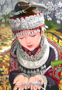

In [133]:
display_image(img_tensor)

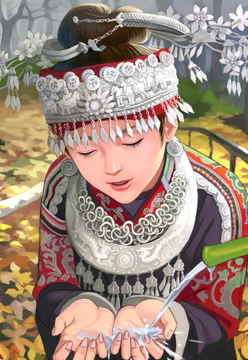

In [134]:
display_image(img_HR_tensor)

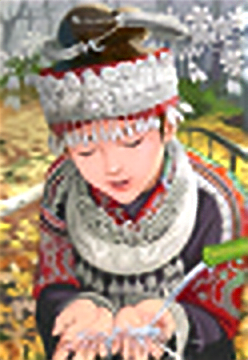

In [135]:
display_image(out_pre)

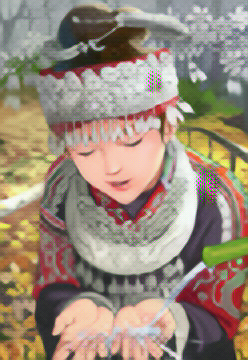

In [136]:
display_image(output)

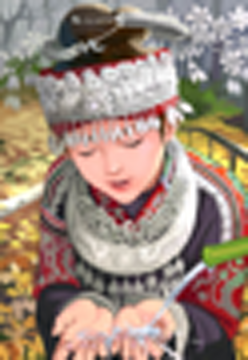

In [137]:
display_image(out_bicubic)

In [140]:
def display_img_panel(lr_tensor, hr_tensor, sr_pre_tensor, sr_final_tensor, sr_bicubic_tensor):
    import matplotlib.pyplot as plt
    import torchvision.transforms as transforms

    lr_img = transforms.ToPILImage()(lr_tensor.squeeze(0).clamp(0, 1).cpu())
    hr_img = transforms.ToPILImage()(hr_tensor.squeeze(0).clamp(0, 1).cpu())
    sr_pre_img = transforms.ToPILImage()(sr_pre_tensor.squeeze(0).clamp(0, 1).cpu())
    sr_final_img = transforms.ToPILImage()(sr_final_tensor.squeeze(0).clamp(0, 1).cpu())
    sr_bicubic_img = transforms.ToPILImage()(sr_bicubic_tensor.squeeze(0).clamp(0, 1).cpu())

    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    axs[0].imshow(lr_img)
    axs[0].set_title('Low Resolution')
    axs[1].imshow(hr_img)
    axs[1].set_title('High Resolution')
    axs[2].imshow(sr_pre_img)
    axs[2].set_title('Super Resolution (Pre-trained)')
    axs[3].imshow(sr_final_img)
    axs[3].set_title('Super Resolution (After GAN)')
    axs[4].imshow(sr_bicubic_img)
    axs[4].set_title('Bicubic Interpolation')

    for ax in axs:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

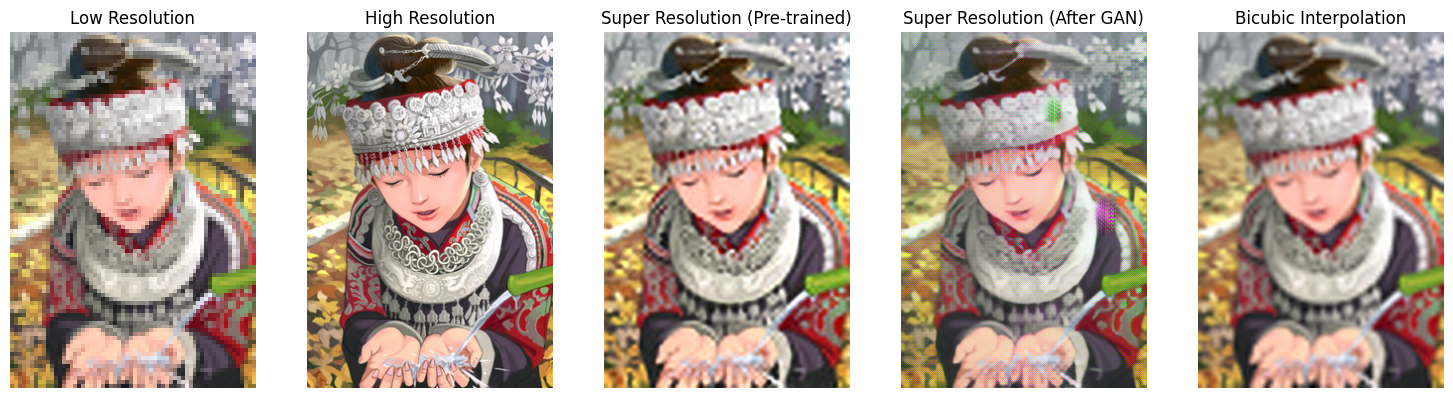

In [141]:
display_img_panel(img_tensor, img_HR_tensor, out_pre, output, out_bicubic)

In [32]:
output_ = output.clamp(0, 1)
save_image(output_, "output_image.png")

In [34]:
img_resume = transforms.ToPILImage()(img_tensor.squeeze(0).cpu())

In [35]:
img == img_resume

True

In [38]:
save_image(output, "srgan_output.png")